## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import Data

In [2]:
df = pd.read_csv("bmw.csv")
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In the dataset above, it can be seen that our features this time are numeric and category, where feature categories include model, transmission, and fuel type

In [3]:
df.shape

(10781, 9)

the dataset this time amounted to 10781 rows and 9 columns

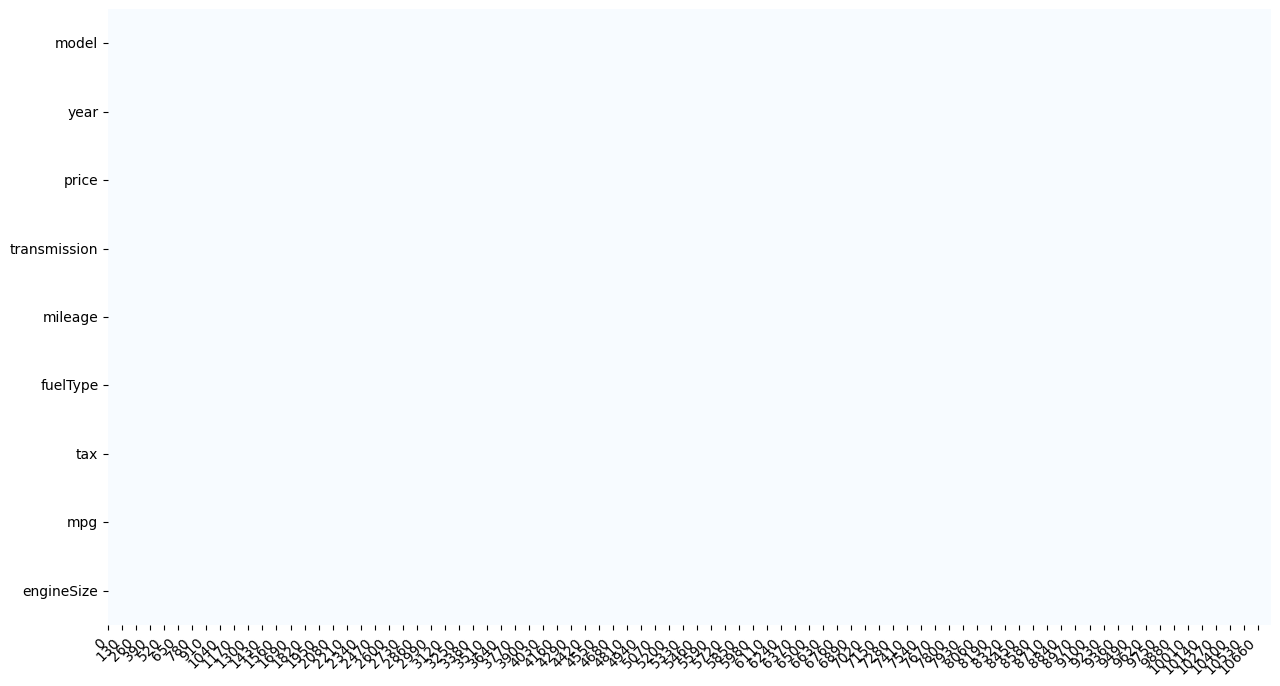

In [4]:
plot_missing_value(df)

In the missing value plot image above, we can see that none of our datasets are empty because the white color means clean of missing values

In [5]:
df.model.unique()

array([' 5 Series', ' 6 Series', ' 1 Series', ' 7 Series', ' 2 Series',
       ' 4 Series', ' X3', ' 3 Series', ' X5', ' X4', ' i3', ' X1', ' M4',
       ' X2', ' X6', ' 8 Series', ' Z4', ' X7', ' M5', ' i8', ' M2',
       ' M3', ' M6', ' Z3'], dtype=object)

The following are the types of models of BMW cars

In [6]:
df.transmission.unique()

array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object)

The following are the types of transmissions types on BMW cars

In [7]:
df.fuelType.unique()

array(['Diesel', 'Petrol', 'Other', 'Hybrid', 'Electric'], dtype=object)

The following are the types of fuel types on BMW cars

## Splitting Data

In [8]:
X = df.drop(columns="price")
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7546, 8), (3235, 8), (7546,), (3235,))

next, we splitting the feature and target data and we use 30% for the test data

## Training

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [10]:
X_train.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
2944,1 Series,2019,Manual,5230,Diesel,145,68.9,2.0
5594,3 Series,2019,Semi-Auto,1020,Diesel,145,52.3,2.0
9069,1 Series,2014,Automatic,17408,Diesel,20,67.3,2.0
9448,2 Series,2015,Automatic,90836,Diesel,30,62.8,2.0
8160,1 Series,2012,Automatic,96596,Diesel,30,64.2,2.0


In [11]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

in this case, we use the XGBoost algorithm and the following parameters we will tune with Randomized SearchCV

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['year','mileage','tax','mpg','engineSize']),
    ('categoric', cat_pipe(encoder='onehot'), ['model','transmission','fuelType']),
])   
#the numeric features that we will use are: year, mileage, tax, mpg, and engine size
#The feature categories that we will use are: model, transmission, and fuel type

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42)),    
]) 
#here we use pipeline to combine numeric and categorical features and model we use XGBoost


model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)
#next, we use the parameters we have specified earlier for tuning and use 3 k-fold and 50 iterations in this case

print(model.best_params_)
print('\n')
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.42066805426927745, 'algo__gamma': 1, 'algo__learning_rate': 0.035015835937029005, 'algo__max_depth': 9, 'algo__n_estimators': 176, 'algo__reg_alpha': 2.772824182801065, 'algo__reg_lambda': 0.0010661259689433889, 'algo__subsample': 0.5553736512887829}


0.9780867972670865 0.943500774556595 0.9483359507464082


we can see the results are very good where our R2 score for the train data is 97% and the test data is 94%

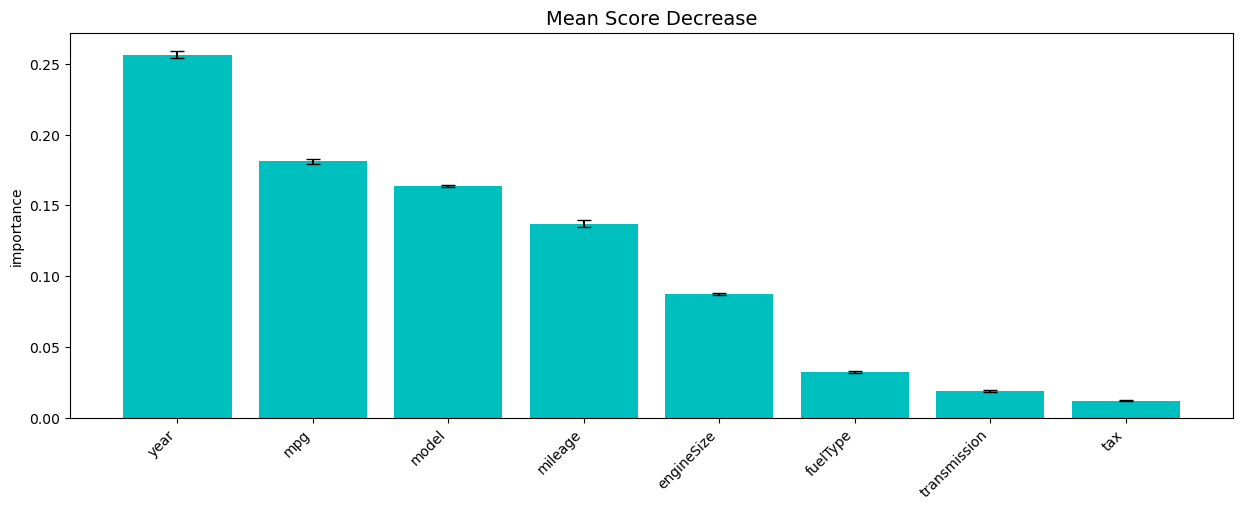

In [13]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

We can see in the picture above where our mean score decreases showing that all the features are useful in the train model process where the one that influences our score is the feature year

## Training with Polynomial

In [14]:
rsp.xgb_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

Next, we try to add a polynomial to the XGBoost algorithm, is it better than the previous model without poly?
and the following are the parameters that we will be tuning

In [15]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['year','mileage','tax','mpg','engineSize']),
    ('categoric', cat_pipe(encoder='onehot'), ['model','transmission','fuelType']),
])
#we use poly=2 to fill our pipeline

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print('\n')
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7273141668957412, 'algo__gamma': 6, 'algo__learning_rate': 0.05235791002299295, 'algo__max_depth': 10, 'algo__n_estimators': 125, 'algo__reg_alpha': 1.739616742284701, 'algo__reg_lambda': 2.9396070097391545, 'algo__subsample': 0.7566202762782357, 'prep__numeric__poly__degree': 2, 'prep__numeric__poly__interaction_only': True}


0.9782054009932196 0.9449460782931984 0.95312270500934


we can see above that using poly only adds 1% to our model, which is nice but 1% will not impact our model result

## Prediction

In [16]:
pred = X_train.iloc[:1]
pred

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
2944,1 Series,2019,Manual,5230,Diesel,145,68.9,2.0


now we try to predict the price of BMW cars using the features above

In [17]:
model.predict(pred)

array([19194.527], dtype=float32)

the model we managed to guess is priced at £19,194

In [18]:
y_train.iloc[:1]

2944    17480
Name: price, dtype: int64

its original price was £17,480

## Exploratory Data Analysis

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

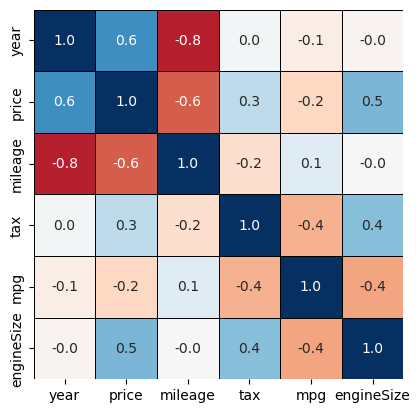

In [20]:
sns.heatmap(df.corr(), annot=True, linewidths=0.5, fmt='.1f', cmap='RdBu', 
            cbar=False, square=True, linecolor='black', vmin=-1, vmax=1);

the following is the correlation between the numerical features in our datasets where feature year, engine size, and tax have a high correlation with our target price

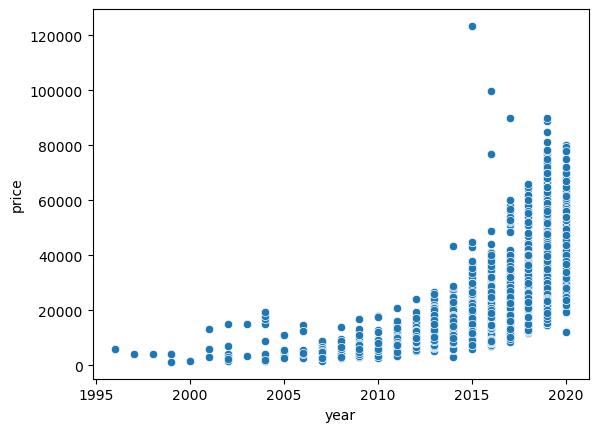

In [21]:
sns.scatterplot(df, x='year', y='price');

In the scatter plot above, we can see that car prices have continued to rise every year from 1995 - 2020

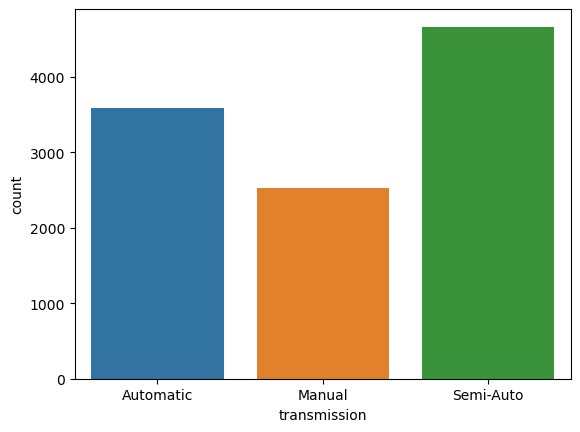

In [22]:
sns.countplot(df, x='transmission');

In the plot above, we can see that the most widely used transmissions are the semi-auto and automatic types, and the lowest manual

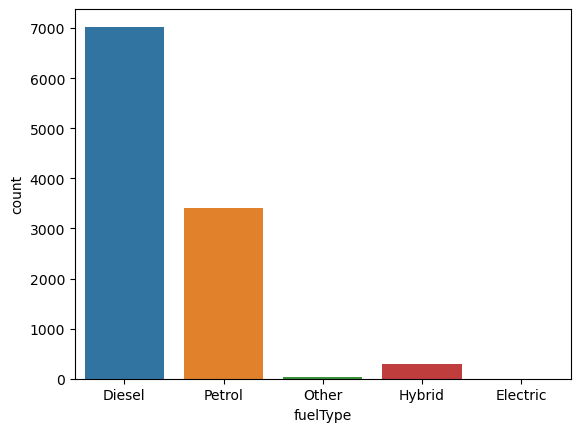

In [23]:
sns.countplot(df, x='fuelType');

In the plot above, we can see that the types of fuel that are widely used are diesel, petrol and
the least use of electric fuel

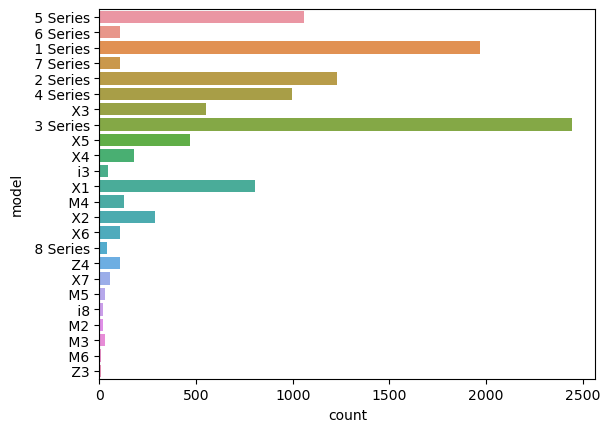

In [24]:
sns.countplot(df, y='model');

we can see that the BMW 3 series has the most number of all types of cars

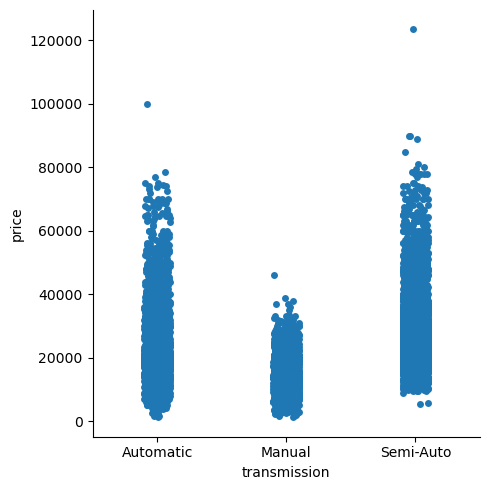

In [25]:
sns.catplot(df, x='transmission', y='price');

In the picture above, we can see that a car with a semi-auto transmission has a higher price than automatic and manual

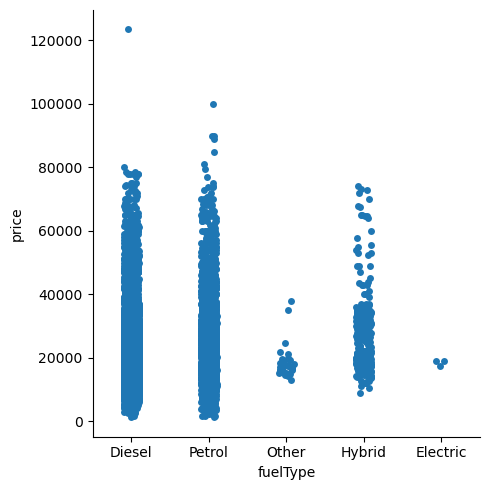

In [26]:
sns.catplot(df, x='fuelType', y='price');

In the picture above, we can see that cars with petrol and diesel fuel have a higher price than hybrids and other fuels

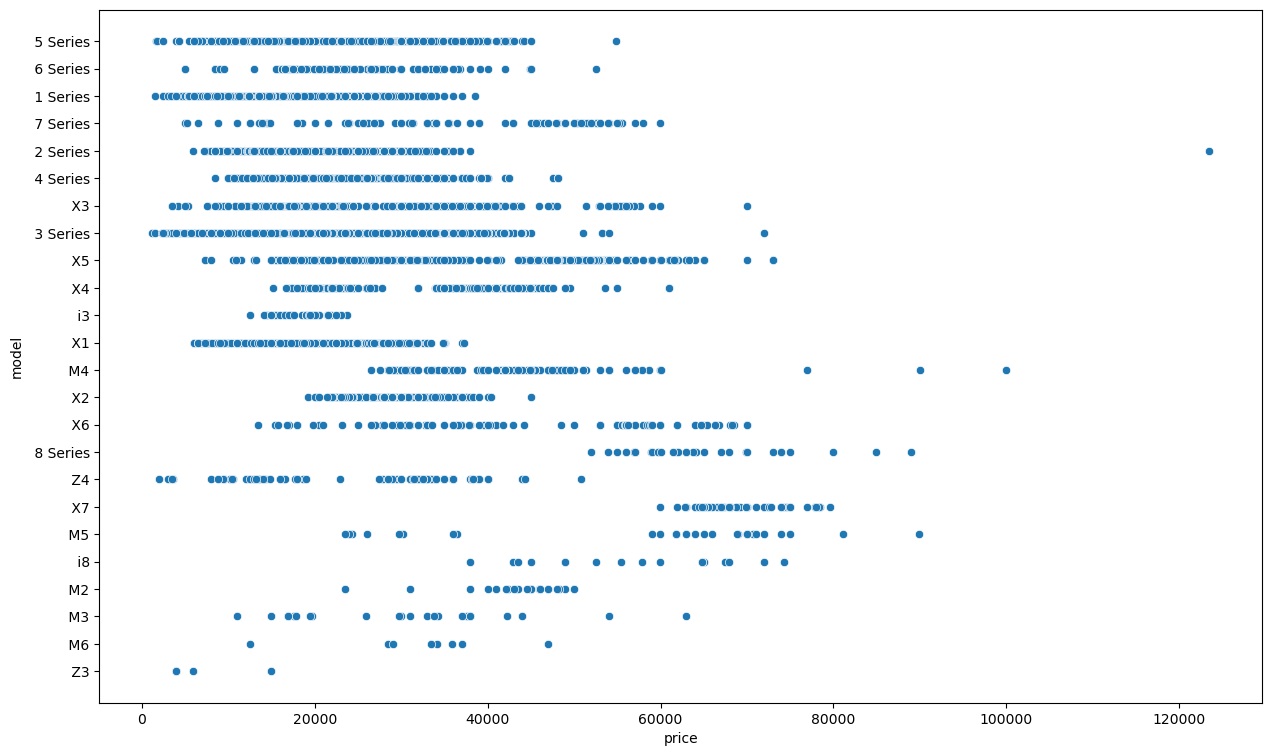

In [27]:
plt.figure(figsize=(15,9))
sns.scatterplot(df, x='price', y='model');

In the picture above you can see the type of BMW cars and their prices

In [28]:
df[df['price']> 120000]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
3638,2 Series,2015,123456,Semi-Auto,33419,Diesel,20,68.9,2.0


there is an oddity where the price of the BMW 2 series car type is very high, namely 123456, maybe it's a typo we don't know for sure, but it's only one car, let's remove the outlier

In [29]:
outlier = df[df['price']> 120000].index
df = df.drop(outlier, axis = 0)

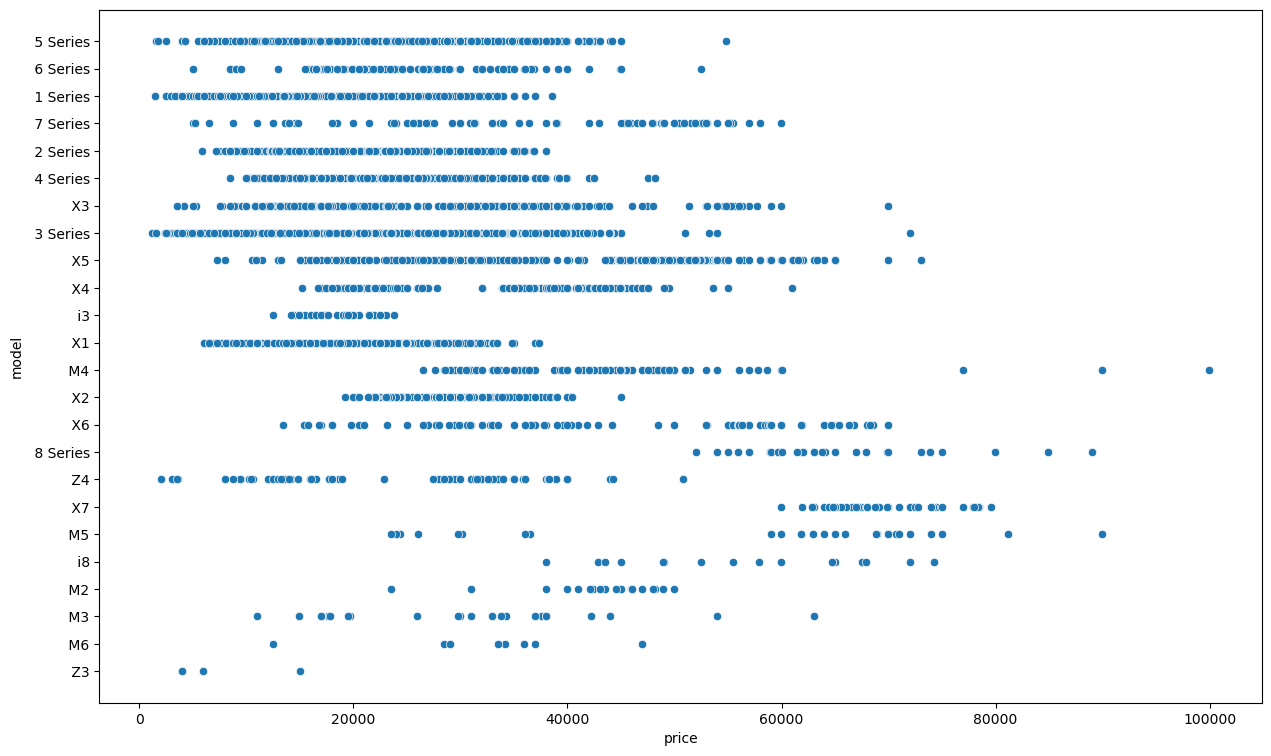

In [30]:
plt.figure(figsize=(15,9))
sns.scatterplot(df, x='price', y='model');

now, the outlier has disappeared and actually our model is very good at 95% where we also don't have a missing value and it doesn't really affect our model. but let's retry the train model

In [31]:
X = df.drop(columns="price")
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7546, 8), (3234, 8), (7546,), (3234,))

In [32]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ['year','mileage','tax','mpg','engineSize']),
    ('categoric', cat_pipe(encoder='onehot'), ['model','transmission','fuelType']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print('\n')
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7402077574737851, 'algo__gamma': 3, 'algo__learning_rate': 0.34877126245459333, 'algo__max_depth': 5, 'algo__n_estimators': 140, 'algo__reg_alpha': 4.5691845768345525, 'algo__reg_lambda': 2.5127790999487307, 'algo__subsample': 0.5247253370691017, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}


0.9787767455991588 0.9503552655814662 0.9576409205343612


we can see that when there are outliers our accuracy is 95.31% and after we remove the outliers it becomes 95.76% a little better than before